In [6]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset
from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import random
import csv
import datetime
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models
import models_redesign
from preprocess_helpers import *
from helper import *
from param_initializations import *
from optimization_strategy import greedy_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

2016-07-01 00:00:00
2018-06-26 19:00:00


<Axes: xlabel='date'>

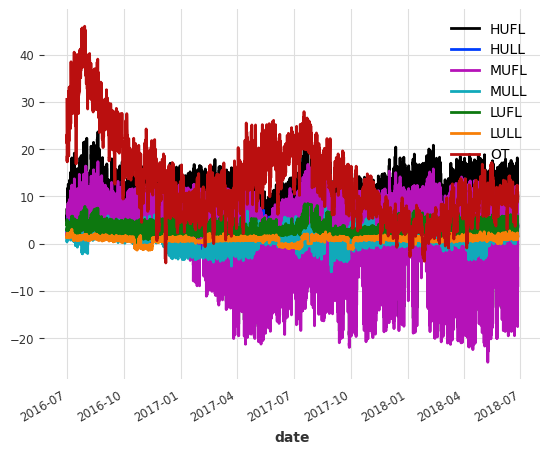

In [7]:
series = ETTh1Dataset().load()

print(series.start_time())
print(series.end_time())

series.plot()

In [8]:
train_series, test_series = series.split_before(0.6)
val_series, test_series = test_series.split_before(0.5)


In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end]
        y = self.targets[end:end + self.pred_len].squeeze(-1) # only OT
        # y = self.data[end:end + self.pred_len, :7].flatten() # all V
        return X, y


In [21]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 1024):
    scaler = StandardScaler()
    
    train, test = series.split_before(0.6)
    val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train_og = train.pd_dataframe()
    train = scaler.fit_transform(train_og)
    train = pd.DataFrame(train, columns=train_og.columns)
    X_train = train
    y_train = train[["OT"]]
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    print(X_train.is_cuda, y_train.is_cuda)
    
    indicators = torch.isfinite(X_train)
    X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    val_og = val.pd_dataframe()
    val = scaler.transform(val_og)
    val = pd.DataFrame(val, columns=val_og.columns)
    X_val = val
    y_val = val[["OT"]]
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_val)
    X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)

    test_og = test.pd_dataframe()
    test = scaler.transform(test_og)
    test = pd.DataFrame(test, columns=test_og.columns)
    X_test = test
    y_test = test[["OT"]]
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    indicators = torch.isfinite(X_test)
    X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


In [22]:
seq_len = 10
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=24)

for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

print("Batches", len(train_loader), len(val_loader), len(test_loader))

Train/Val/Test 10451 3484 3485
False False


RuntimeError: Caught RuntimeError in pin memory thread for device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 32, in do_one_step
    data = pin_memory(data, device)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 68, in pin_memory
    return type(data)([pin_memory(sample, device) for sample in data])  # type: ignore[call-arg]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 68, in <listcomp>
    return type(data)([pin_memory(sample, device) for sample in data])  # type: ignore[call-arg]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 53, in pin_memory
    return data.pin_memory(device)
RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.


In [12]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title):
    plt.plot(history[:, 0], history[:, 2], label='MAE')
    plt.plot(history[:, 0], history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(history[:, 0])
    plt.xscale('log')

    for x,_y in zip(history[:, 0], history[:, 2]):
        label = "{:.2f}".format(_y)
        plt.annotate(label, # this is the text
                    (x,_y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center
        
    for x,_y in zip(history[:, 0], history[:, 3]):
        label = "{:.2f}".format(_y)
        plt.annotate(label, # this is the text
                    (x,_y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


In [19]:
def initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models.CBM(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

def initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim, top_k=''):
    model = models_redesign.CBM_redesigned(input_dim = input_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            opt_lr = 3e-3, # 2e-4
                            opt_weight_decay = 1e-05,
                            l1_lambda=0.001,
                            cos_sim_lambda=0.01,
                            output_dim = output_dim,
                            top_k=top_k,
                            task_type=models_redesign.TaskType.REGRESSION,
                            )
    model = model.to(device)
    return model

In [20]:
random_seed = 1
set_seed(random_seed)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [15]:
seq_len = 96
pred_len = 96


## Original

In [17]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L{seq_len}-T{pred_len}/"
model_path_og = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [18]:
history_og = []

changing_dim = len(series.columns)
input_dim = 2 * changing_dim
n_concepts_list = list(range(2,21,2)) + list(np.arange(50,401,50))

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), round(mae,2), round(mse,2)]
    display(history)
    history_og.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_og = np.array(history_og)
history_og.shape


Train/Val/Test 10451 3484 3485
n_concepts 2


AttributeError: module 'models' has no attribute 'CBM_redesigned'

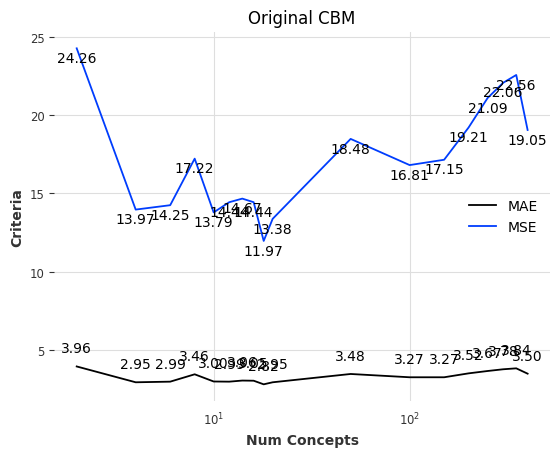

In [12]:
plot_mae_mse(history_og, "Original")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 2

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_og.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plt.plot(yb, color="black", label="True")
plt.plot(preds, color="red", label="Pred")
plt.legend()
plt.show()


## Redesigned

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-multi2single-L{seq_len}-T{pred_len}/"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re = []

changing_dim = len(series.columns)
input_dim = 2 * changing_dim
n_concepts_list = list(range(2,21,2)) + list(np.arange(50,401,50))

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), round(mae,2), round(mse,2)]
    display(history)
    history_re.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_re = np.array(history_re)
history_re.shape


In [ ]:
plot_mae_mse(history_re, "Redesigned")


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 2

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plt.plot(yb, color="black", label="True")
plt.plot(preds, color="red", label="Pred")
plt.legend()
plt.show()


## Redesigned + Scheduler

In [ ]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-scheduler-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_sched = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_re_sched = []

changing_dim = len(series.columns)
input_dim = 2 * changing_dim
n_concepts_list = list(range(2,21,2)) + list(np.arange(50,401,50))

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(patience=2)
    # LambdaLR
    # lr_lambda = lambda epoch: 0.5 ** ((epoch - 1) // 1)
    model.fit(train_loader, val_loader, None, save_model_path=model_path_re_sched.format(n_concepts), max_epochs=10000, patie scheduler=scheduler)
    
    display(model)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), round(mae,2), round(mse,2)]
    display(history)
    history_re_sched.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_re_sched = np.array(history_re_sched)
history_re_sched.shape


In [ ]:
plot_mae_mse(history_re_sched, "Redesigned + Scheduler")


Train/Val/Test 10451 3484 3485
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/multi2single-L96-T96/forecasting_c100.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


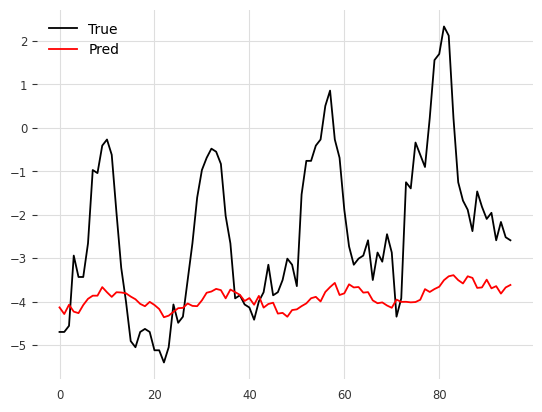

In [13]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 100

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re_sched.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plt.plot(yb, color="black", label="True")
plt.plot(preds, color="red", label="Pred")
plt.legend()
plt.show()


## Redesign + Warmup

In [20]:
experiment_folder = f"/workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-warmup-multi2single-L{seq_len}-T{pred_len}/"
model_path_re_wa = experiment_folder + "forecasting_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train/Val/Test 10451 3484 3485
n_concepts 2


 16%|█▌        | 1599/10000 [07:22<38:46,  3.61it/s]

Early Stopped


[2, 95.78, 5.68, 43.76]

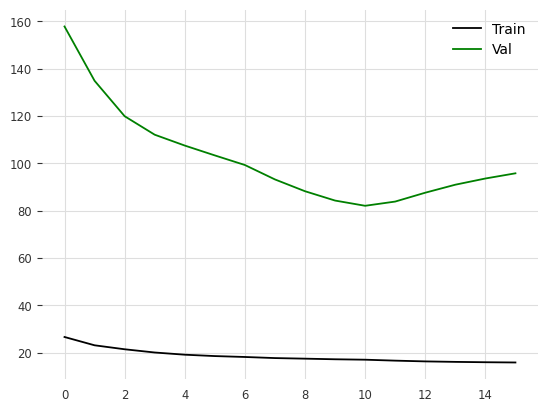

n_concepts 4


 16%|█▌        | 1599/10000 [07:20<38:36,  3.63it/s]

Early Stopped


[4, 51.92, 4.13, 25.0]

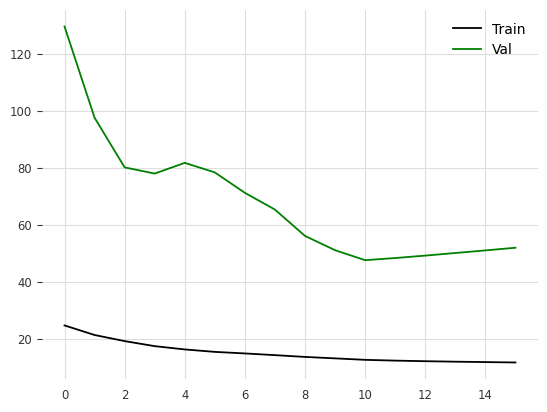

n_concepts 6


 16%|█▌        | 1599/10000 [07:22<38:45,  3.61it/s]

Early Stopped


[6, 74.59, 4.7, 31.94]

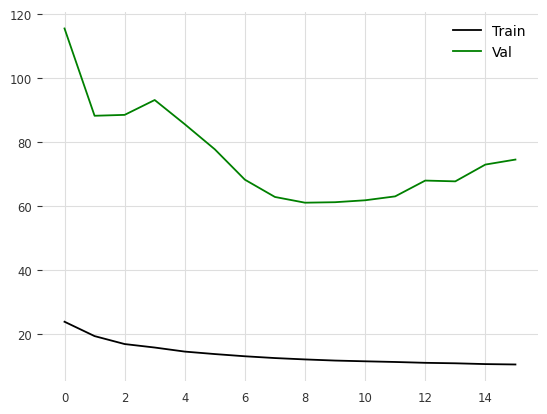

n_concepts 8


 20%|█▉        | 1999/10000 [09:13<36:56,  3.61it/s]

Early Stopped


[8, 68.05, 4.55, 31.33]

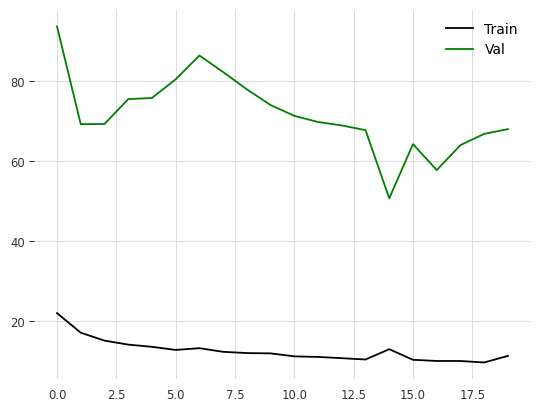

n_concepts 10


 17%|█▋        | 1699/10000 [07:55<38:42,  3.57it/s]

Early Stopped


[10, 62.31, 4.47, 27.94]

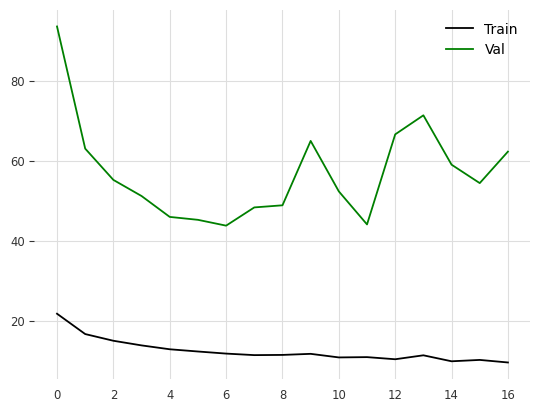

n_concepts 12


 21%|██        | 2099/10000 [09:42<36:33,  3.60it/s]

Early Stopped


[12, 129.1, 7.25, 64.38]

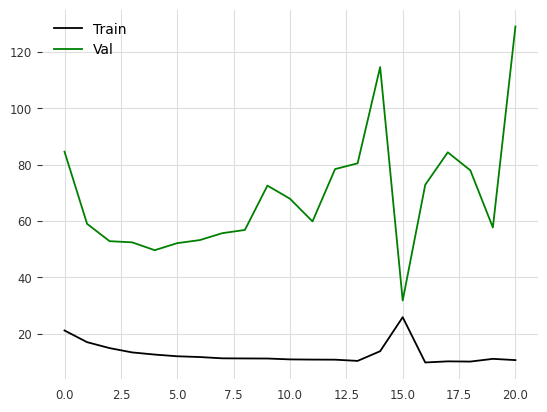

n_concepts 14


 17%|█▋        | 1699/10000 [07:51<38:25,  3.60it/s]

Early Stopped


[14, 79.01, 4.71, 31.62]

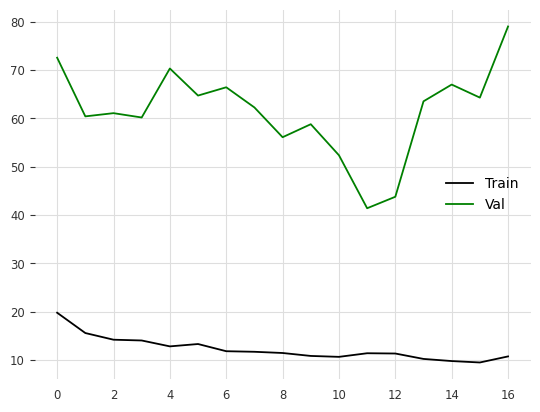

n_concepts 16


 19%|█▉        | 1899/10000 [08:53<37:55,  3.56it/s]

Early Stopped


[16, 69.17, 3.9, 23.44]

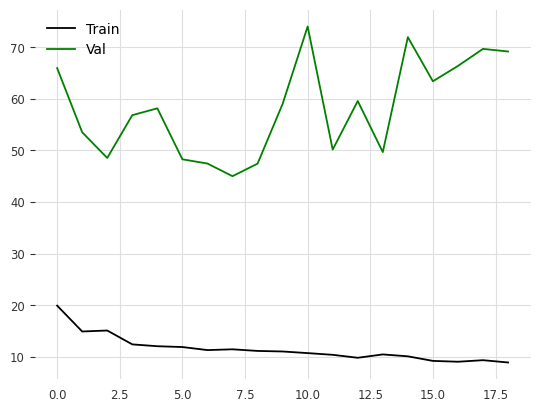

n_concepts 18


 17%|█▋        | 1699/10000 [07:53<38:33,  3.59it/s]

Early Stopped


[18, 72.13, 4.1, 25.63]

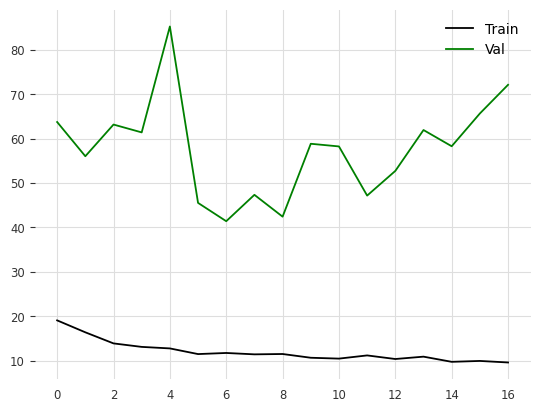

n_concepts 20


 19%|█▉        | 1899/10000 [08:48<37:34,  3.59it/s]

Early Stopped


[20, 52.22, 2.86, 14.59]

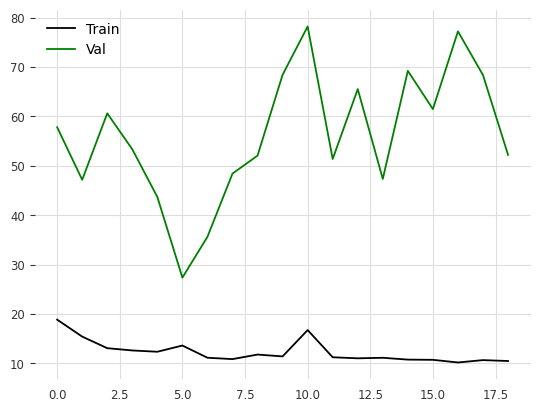

n_concepts 50


 23%|██▎       | 2299/10000 [10:44<35:59,  3.57it/s]

Early Stopped


[50, 60.45, 3.63, 20.67]

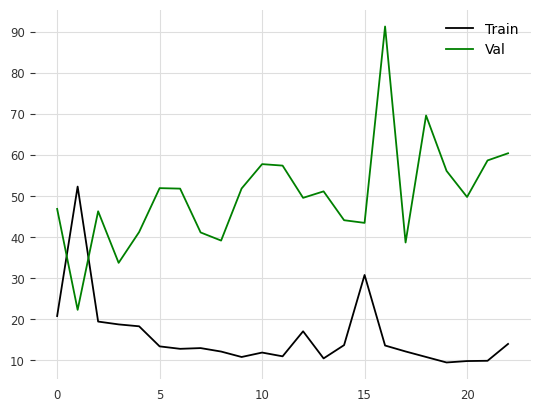

n_concepts 100


 21%|██        | 2099/10000 [09:53<37:15,  3.53it/s]

Early Stopped


[100, 99.61, 5.93, 46.44]

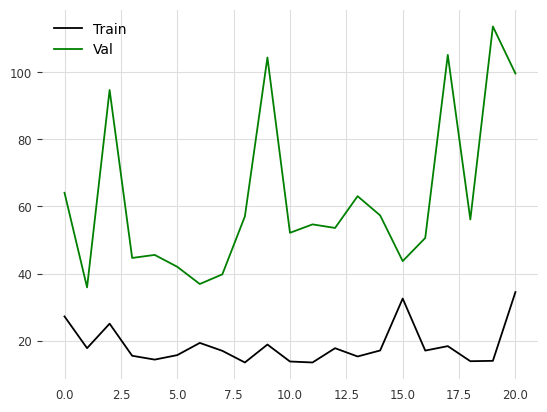

n_concepts 150


 18%|█▊        | 1799/10000 [08:43<39:47,  3.44it/s]

Early Stopped


[150, 54.19, 2.61, 11.96]

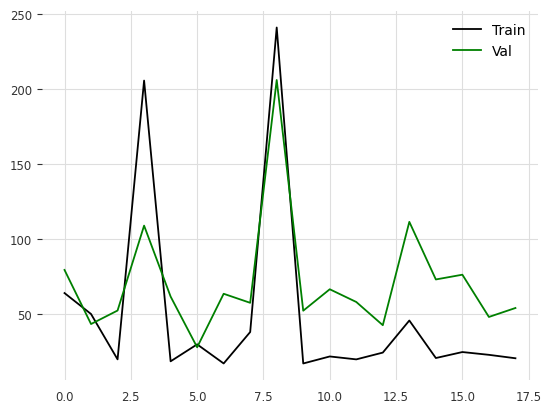

n_concepts 200


 17%|█▋        | 1699/10000 [08:30<41:33,  3.33it/s] 

Early Stopped


[200, 284.3, 12.18, 161.59]

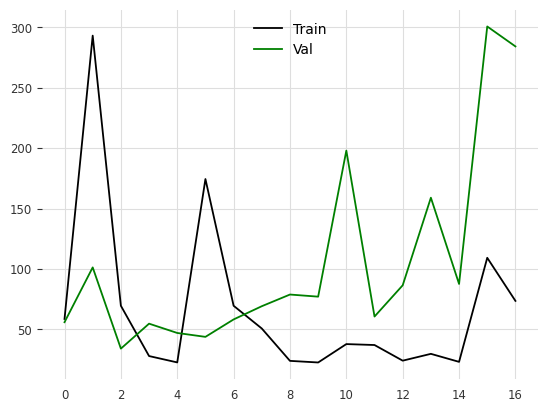

n_concepts 250


 20%|█▉        | 1999/10000 [10:28<41:56,  3.18it/s] 

Early Stopped


[250, 109.99, 5.75, 43.02]

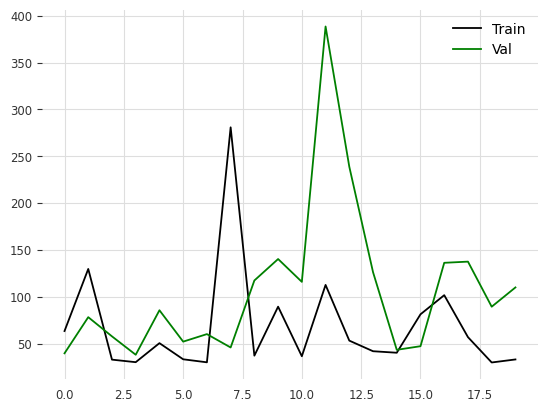

n_concepts 300


 18%|█▊        | 1799/10000 [10:02<45:47,  2.99it/s]  

Early Stopped


[300, 66.08, 6.06, 47.2]

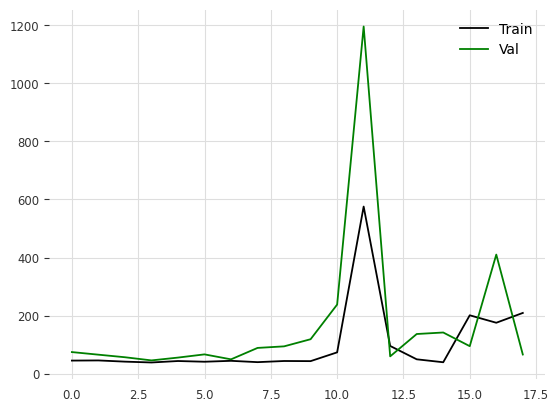

n_concepts 350


 16%|█▌        | 1599/10000 [09:37<50:33,  2.77it/s]  

Early Stopped


[350, 511.27, 17.08, 329.65]

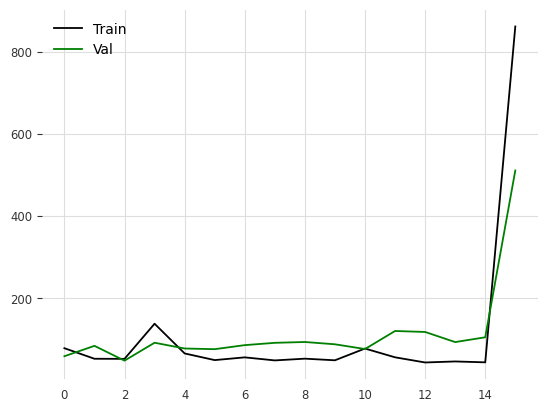

n_concepts 400


 17%|█▋        | 1699/10000 [10:47<52:41,  2.63it/s]  

Early Stopped


[400, 96.21, 2.73, 12.96]

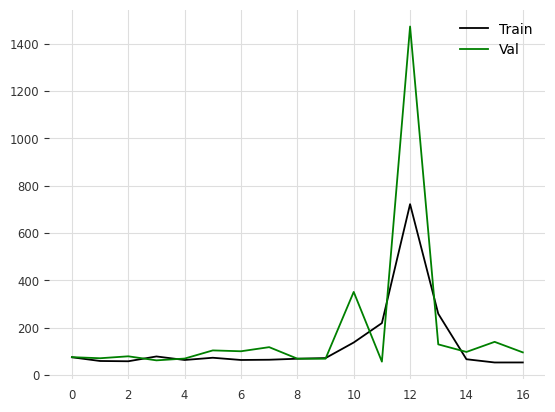

(18, 4)

In [21]:
history_re_wa = []

set_seed(random_seed)

changing_dim = len(series.columns)
input_dim = 2 * changing_dim
n_concepts_list = list(range(2,21,2)) + list(np.arange(50,401,50))

train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)

for n_concepts in n_concepts_list:
    print("n_concepts", n_concepts)
    
    model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
    model.fit(train_loader, val_loader, None, model_path_re_wa.format(n_concepts), max_epochs=10000, warmup_epochs=1000)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (Xb, yb) in enumerate(test_loader):
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model.forward(Xb)
            
            mae = mae_metric(preds, yb).item()
            mse = mse_metric(preds, yb).item()
        mae = mae_metric.compute().item()
        mse = mse_metric.compute().item()
        mae_metric.reset()
        mse_metric.reset()
    
    history = [n_concepts, round(model.val_losses[-1],2), round(mae,2), round(mse,2)]
    display(history)
    history_re_wa.append(np.array(history))
    
    plot_losses(model.train_losses, model.val_losses)
    
history_re_wa = np.array(history_re_wa)
history_re_wa.shape


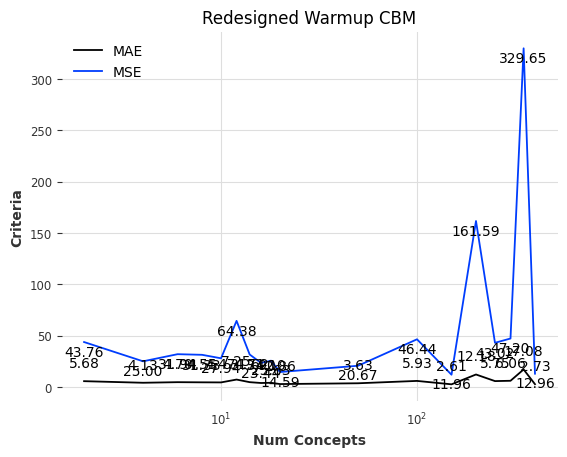

In [22]:
plot_mae_mse(history_re_wa, "Redesign + Warmup")


Train/Val/Test 10451 3484 3485
Loaded model from /workdir/optimal-summaries-public/vasopressor/models/etth1/redesign-warmup-multi2single-L96-T96/forecasting_c100.pt


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(96,)
(96,)


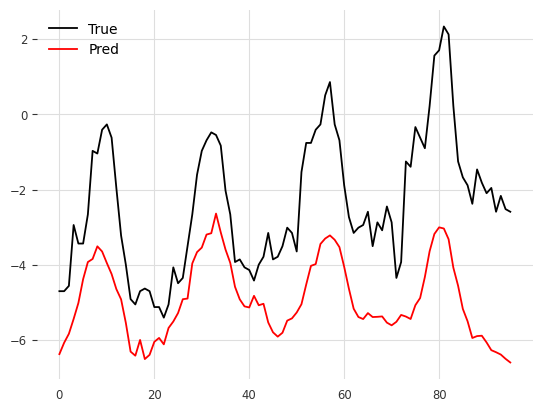

In [23]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)
n_concepts = 100

model = initializeModel_redesigned(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)
model.fit(train_loader, val_loader, None, save_model_path=model_path_re_wa.format(n_concepts), max_epochs=10000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(val_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model.forward(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
        break
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()


i = 20
yb = yb.cpu().numpy()[i]
preds = preds.cpu().numpy()[i]

print(yb.shape)
print(preds.shape)

plt.plot(yb, color="black", label="True")
plt.plot(preds, color="red", label="Pred")
plt.legend()
plt.show()


## Optimization

In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len)
model.fit(train_loader, val_loader, None, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
best_aucs, best_auc_inds, best_auc_concepts = greedy_selection(auroc_metric, test_loader, top_k_inds, model)


In [ ]:
filename = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["Best AUC", "Best AUC Concept #", "Best AUC ind #"])
    # writing the data rows 
    for row in zip(best_aucs, best_auc_concepts, best_auc_inds):
        csvwriter.writerow(list(row))


## Multi-class

In [ ]:
experiment_folder = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/"
model_path = experiment_folder + "arabic_c{}.pt"
random_seed = 1

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [ ]:
history_multiclass = []

set_seed(random_seed)

data, y_ohe, num_classes, weights = preprocess_data_multiclass(X, y)
train_loader, val_loader, test_loader = initialize_data(1, data, y_ohe, multiclass=True)

input_dim = data.shape[2]
changing_dim = X[0].shape[0]
seq_len = data.shape[1]

auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

for n_concepts in range(1,16):
    print(n_concepts)
    
    model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
    model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)
    
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
    history = [n_concepts, model.val_losses[-1], auc, acc]
    history_multiclass.append(np.array(history))
history_multiclass = np.array(history_multiclass)
history_multiclass.shape


In [ ]:
# plot
plt.plot(history_multiclass[:, 0], history_multiclass[:, 2], label='AUC')
plt.plot(history_multiclass[:, 0], history_multiclass[:, 3], label='ACC')

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')
plt.xticks(np.arange(min(history_multiclass[:, 0]), max(history_multiclass[:, 0])+1, 1))

for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 2]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,_y in zip(history_multiclass[:, 0], history_multiclass[:, 3]):
    label = "{:.2f}".format(_y)
    plt.annotate(label, # this is the text
                 (x,_y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.legend()
plt.show()


In [ ]:
# feature weights
n_concepts = 5

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head()

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
data_cols = [i for i in range(1,14)] + [str(i) + "_ind" for i in range(1,14)]

sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"])
plt.plot(greedy_results["acc"])
plt.show()

In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, weights, save_model_path="/workdir/optimal-summaries-public/vasopressor/models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", epochs=3000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model.forward_probabilities(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)
